# Backtesting an ML strategy with Backtrader

## Imports & Settings

In [27]:
import warnings

from tqdm import tqdm

warnings.filterwarnings('ignore')

In [28]:
#%matplotlib inline

from pathlib import Path
import csv
from time import time
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns

import backtrader as bt
from backtrader.feeds import PandasData

import pyfolio as pf

from data.data_loader import data_loader

In [29]:
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)
sns.set_style('darkgrid')

In [30]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

## Backtrader Setup

### Custom Commission Scheme

In [31]:
# https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/
# https://medium.com/@gk_/crypto-quant-programmatic-trading-of-btc-using-binance-and-backtrader-part-2-of-3-d8af44c93e2b
class CommInfoFractional(bt.CommissionInfo):
    params = dict(stocklike=True,
                  commission=.0075,
                  commtype = bt.CommInfoBase.COMM_PERC)# No margin, no multiplier
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)


### DataFrame Loader


In [32]:
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    OHLCV = ['open', 'high', 'low', 'close', 'volume']
    cols = OHLCV + ['predicted']

    # create linesReceives a timer notification where timer is the timer which was returned by add_timer, and when is the calling time. args and kwargs are any additional arguments passed to add_timer
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

### Create and Configure Cerebro Instance

In [33]:
def create_cerebro():
    cerebro = bt.Cerebro()  # create a "Cerebro" instance
    cash = 10000
    cerebro.broker.addcommissioninfo(CommInfoFractional())
    cerebro.broker.setcash(cash)
    return cerebro

cerebro = create_cerebro()

### Add input data


In [34]:
results_path = Path('results_5Min_ncut_1obsy_lbackfac_1')
start_date="2021-3"
end_date="2021-3"


def get_eval_data(results_path,
                  start_date=None,
                  end_date=None):

    factors = (pd.read_feather(results_path /'test_preds.ftr').set_index(['ticker', 'date'])
                   .loc[:, :'# 3']
                   .mean(1)
                   .to_frame('predicted')
                    .sort_index())

    idx = pd.IndexSlice
    #factors = (factors.loc[idx[:, offset, :], :].reset_index('offset', drop=True))
    if start_date is not None and end_date is not None:
        factors = (factors.loc[idx[:, start_date:end_date], :])

    tickers = factors.index.get_level_values('ticker').unique()
    start_date=factors.index.get_level_values('date').min()
    end_date=factors.index.get_level_values('date').max()
    print(f'from {start_date} to {end_date}')

    factors = (factors
          .dropna(how='all')
          .sort_index().tz_localize('UTC', level='date'))


    prices = pd.read_feather(results_path / 'prices.ftr').set_index(['date', 'ticker'])
    prices = (prices.reorder_levels(['ticker', 'date']).sort_index())

    idx = pd.IndexSlice
    prices = (prices.loc[idx[tickers, start_date:end_date], :])

    # prices.reset_index('offset', drop=True, inplace=True)
    prices = (prices.sort_index().tz_localize('UTC', level='date'))
    return prices, factors


prices, factors = get_eval_data(results_path, start_date=start_date, end_date=end_date)
data = factors.join(prices)

data.groupby('ticker').head()


from 2021-03-01 00:00:00 to 2021-03-31 23:55:00


predicted        open       close         low        high       volume
ticker   date                                                                                             
algo-usd 2021-03-01 00:00:00+00:00   0.000297    1.017900    1.017900    1.017100    1.017900    47.526139
         2021-03-01 00:05:00+00:00   0.000022    1.030100    1.030100    1.020000    1.030100   129.786703
         2021-03-01 00:10:00+00:00  -0.000104    1.017800    1.017800    1.014100    1.017800    95.314200
         2021-03-01 00:15:00+00:00   0.000315    1.018700    1.018700    1.018400    1.031600  4118.981623
         2021-03-01 00:20:00+00:00   0.000022    1.033600    1.033600    1.032000    1.040500  6826.719076
...                                       ...         ...         ...         ...         ...          ...
zec-usd  2021-03-01 00:00:00+00:00   0.000356  111.029999  111.029999  111.029999  111.949997    13.750000
         2021-03-01 00:05:00+00:00   0.001645  112.139999  112.139999  111.250000  112.139999     6.770435
         2021-03-01 00:10:00+00:00  -0.008416  111.379997  111.379997  110.690002  111.379997     9.045148
         2021-03-01 00:15:00+00:00   0.000190  111.160004  111.160004  111.160004  111.589996     0.300000
         2021-03-01 00:20:00+00:00   0.000205  112.139999  112.139999  112.139999  113.290001     7.394272

[160 rows x 6 columns]

In [35]:
#counts_df = data.groupby('date').count()
#counts_df.plot()

In [36]:
#data.groupby('ticker').count().plot()

In [37]:
#data=data.swaplevel()
#data

In [38]:

print("loading...")
def bt_adddata(bt_cerebro, data):
    idx = pd.IndexSlice
    tickers = data.index.get_level_values('ticker').unique()
    benchmark_btc = None

    for ticker in tqdm(tickers):
        df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
        df.index.name = 'datetime'
        bt_data = SignalData(dataname=df)
        bt_cerebro.adddata(bt_data, name=ticker)
        if ticker == 'btc-usd':
            benchmark_btc = df
    return benchmark_btc
benchmark_btc = bt_adddata(bt_cerebro=cerebro, data=data)
benchmark_btc

100%|██████████| 32/32 [00:00<00:00, 631.54it/s]

loading...


,predicted,open,close,low,high,volume
datetime,,,,,,
2021-03-01 00:00:00+00:00,-0.000013,45072.722656,45072.722656,45072.722656,45414.000000,49.396901
2021-03-01 00:05:00+00:00,0.003624,45397.000000,45397.000000,45116.000000,45500.000000,39.688833
2021-03-01 00:10:00+00:00,0.000022,45117.000000,45117.000000,45100.000000,45455.000000,12.235831
2021-03-01 00:15:00+00:00,0.000535,45333.000000,45333.000000,45333.000000,45734.000000,52.571492
2021-03-01 00:20:00+00:00,-0.000110,45734.000000,45734.000000,45705.000000,46440.000000,176.116222
...,...,...,...,...,...,...
2021-03-31 23:35:00+00:00,0.000022,58814.691406,58814.691406,58814.691406,58893.000000,14.407868
2021-03-31 23:40:00+00:00,0.000022,58837.000000,58837.000000,58756.000000,58839.000000,16.412288
2021-03-31 23:45:00+00:00,0.000022,58757.000000,58757.000000,58757.000000,58872.199219,2.712142


In [39]:
data = None
prices = None
factor = None

### Strategy

Includes an option to only trade on certain weekdays in lines 39/40.


In [40]:
class MLStrategy_relative(bt.Strategy):
    params = (('n_positions', 20),
              ('min_positions', 1),
              ('verbose', False),
              ('log_file', 'MLStrategy_relative.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))


    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
        # print(self.datas[0].datetime)
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # get number of available tickers
        n_available_tickers = len(self.datas)
        self.log(f'{n_available_tickers} available on {today}')

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)

        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
        short_target = -0.999 / max(self.p.n_positions, n_shorts)
        long_target = 0.999 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')



### Run Strategy Backtest

In [41]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.SQN, _name='sqn')
cerebro.addanalyzer(bt.analyzers.SharpeRatio)

In [42]:
n_positions = [20, 30]
min_positions = [1, 2]

In [43]:
opt = False
if opt:
    print("optimize strategy")
    cerebro.optstrategy(MLStrategy_relative, verbose=True,
                        min_positions=min_positions,
                        n_positions=n_positions)

    start = time()

    results = cerebro.run(stdstats=False, optreturn=False)
    # ending_value = cerebro.broker.getvalue()
    print(f'Duration: {format_time(time() - start)}')

    results_kpis = []
    results_kpis2 = []
    for result in results:
        sqn_dict = result[0].analyzers.getbyname('sqn').get_analysis()
        assert sqn_dict['trades'] > 30
        results_kpis.append(
                    [sqn_dict['sqn'],
                    round(result[0].broker.getvalue()),
                    result[0].p.min_positions,
                    result[0].p.n_positions,
                    result[0]])

    results_kpis.sort(reverse=True)

    best_strategy = results_kpis[0][4]

    results_kpis_df = pd.DataFrame(data=[sublist[:4] for sublist in results_kpis],
                               columns=['sqn','value','par min_positions','par n_positions'])

    results_kpis_df.head(10)


    fig, ax = plt.subplots(ncols=1, figsize=(6, 6))

    sns.scatterplot(x="par min_positions", y="par n_positions",
                    size="value", hue="sqn", linewidth=0,
                    data=results_kpis_df, ax=ax)

else:
    print('run strategy')
    cerebro.addstrategy(MLStrategy_relative,
                        verbose=True,
                        min_positions=1,
                        n_positions=10)
    result = cerebro.run(stdstats=False, optreturn=False)
    best_strategy = result[0]

    sqn_dict = best_strategy.analyzers.getbyname('sqn').get_analysis()
    assert sqn_dict['trades'] > 30
    print(f"SQN number {sqn_dict['sqn']}")
    print(f"Account Value {best_strategy.broker.getvalue()}")


run strategy
SQN number -33.14199955400547
Account Value 1.1767447297348815e-54


### Plot result

Disabled because large number of datafeeds all plot separately.

In [44]:
#figure = cerebro.plot(iplot=True, volume=False)[0][0]
#cerebro.plot()  # plot the results
#figure = cerebro.plot(iplot=False)[0][0]
#figure.savefig(f'backtrader2.svg')
#figure.show()



### Sort for best strategy


### Analyzer results

In [45]:
pyfolio_analyzer = best_strategy.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [46]:
# results[0][0].analyzers.getbyname('tradeanalyzer').print()


### Get `pyfolio` inputs

In [47]:
#benchmark = web.DataReader('SP500', 'fred', '2017', '2022').squeeze()
#benchmark = benchmark.resample('D')
#benchmark = benchmark.ffill()
#benchmark = benchmark.dropna()
#benchmark = benchmark.pct_change().tz_localize('UTC')
#benchmark

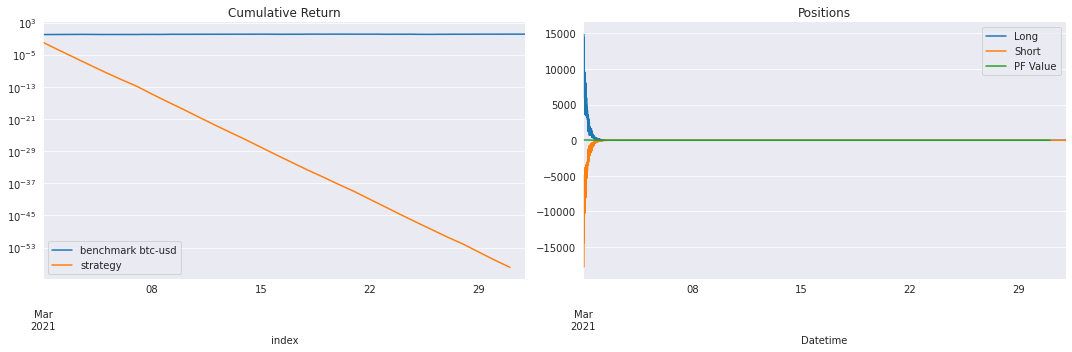

In [48]:
benchmark_btc2 = benchmark_btc['close'].pct_change().rename('btc/usd-benchmark')

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
log_axs=1
if log_axs:
    axes[0].set_yscale('log')
    benchmark_btc2.add(1).cumprod().plot(ax=axes[0], title='Cumulative Return', label="benchmark btc-usd")
    returns.add(1).cumprod().plot(ax=axes[0], title='Cumulative Return', label='strategy')
else:
    benchmark_btc2.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return', label="benchmark btc-usd")
    returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return', label='strategy')
axes[0].legend()

daily_tx = transactions.groupby(level=0)
longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())
longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout()


In [49]:
# prepare pyfolio inputs
#pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
#returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

returns.to_hdf('backtrader.h5', 'returns')
positions.to_hdf('backtrader.h5', 'positions')
transactions.to_hdf('backtrader.h5', 'transactions/')
gross_lev.to_hdf('backtrader.h5', 'gross_lev')


## Run pyfolio analysis

In [50]:
returns = pd.read_hdf('backtrader.h5', 'returns')
positions = pd.read_hdf('backtrader.h5', 'positions')
transactions = pd.read_hdf('backtrader.h5', 'transactions/')
gross_lev = pd.read_hdf('backtrader.h5', 'gross_lev')


Start date,2021-03-01
End date,2021-03-31
Total months,1
,Backtest
Annual return,-100.0%
Cumulative returns,-100.0%
Annual volatility,3.967%
Sharpe ratio,-6265.33
Calmar ratio,-1.00
Stability,1.00
Max drawdown,-100.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,100.00,2021-03-01,2021-03-10,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2021-03-31 00:00:00+0000', tz='UTC'))

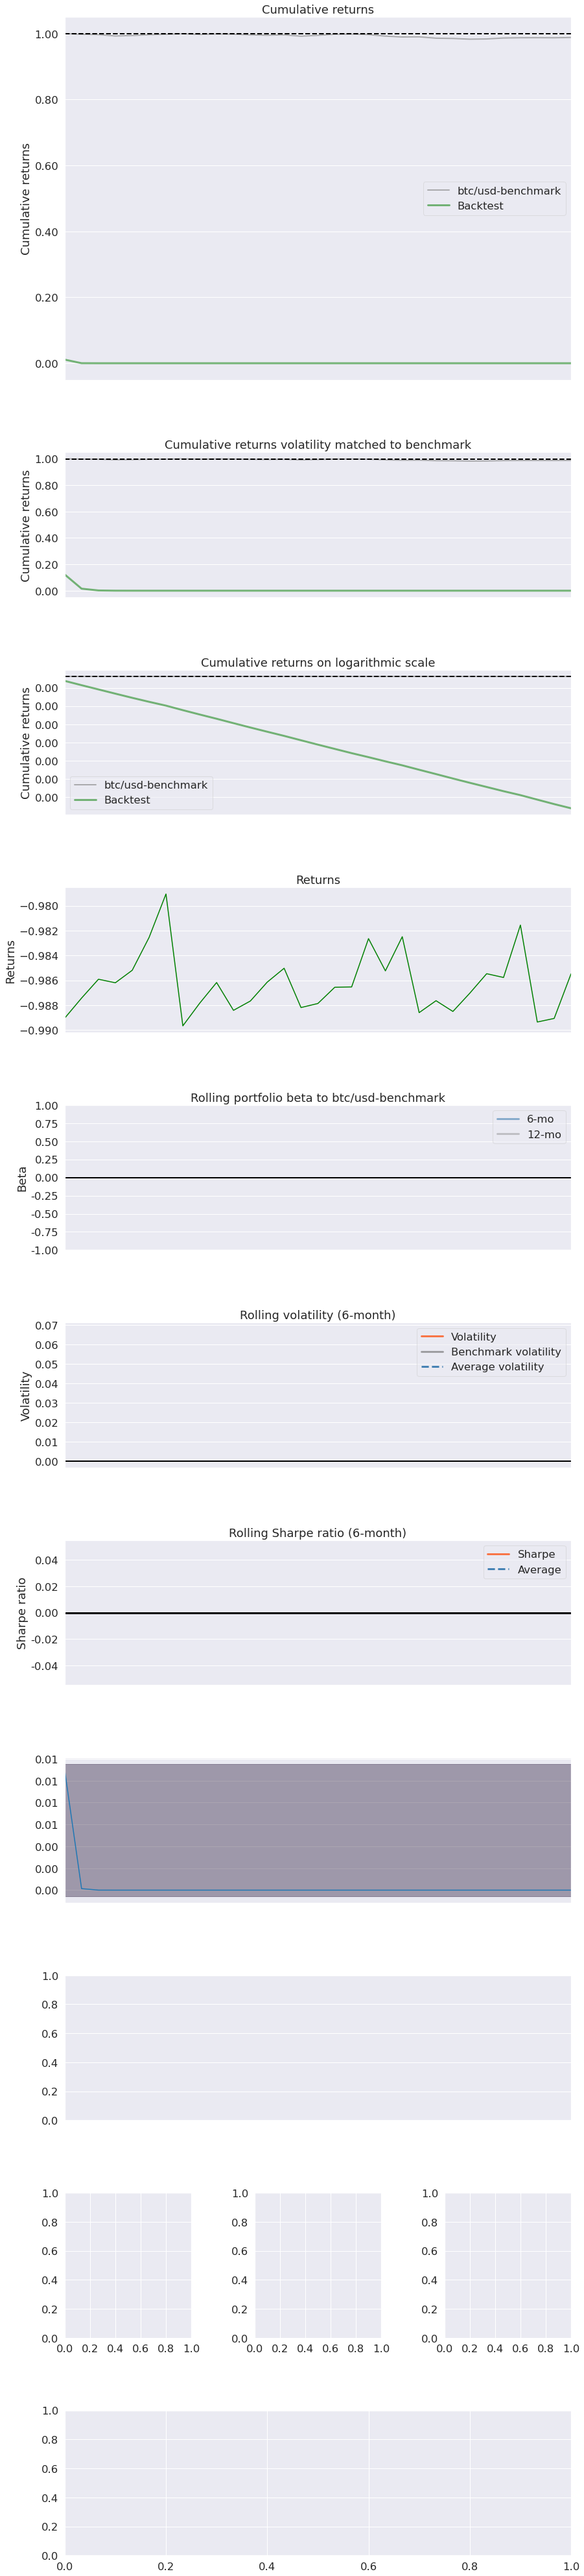

In [51]:
pyfolio = pf.create_full_tear_sheet(returns,
                          transactions=transactions,
                          positions=positions,
                          benchmark_rets=benchmark_btc2)


